{'eval_method': '3_fold', 'model_name': 'llama3.2:3b-instruct-fp16'}
Index(['model_name', 'task_id', 'candidate_id', 'metric', 'error_type',
       'error_msg', 'code_candidate', 'test_result', 'stderr', 'stdout',
       'phase', 'seed', 'temperature', 'top_p', 'top_k', 'created_at',
       'eval_method', 'fold', 'syntax_error', 'syntax_category',
       'semantic_error', 'semantic_category', 'tests_category', 'tests_error'],
      dtype='object')
['syntax' 'semantic' 'tests']
              category  count  percentage
0       Parsing failed   1374   96.624473
1  Tokenization failed     48    3.375527


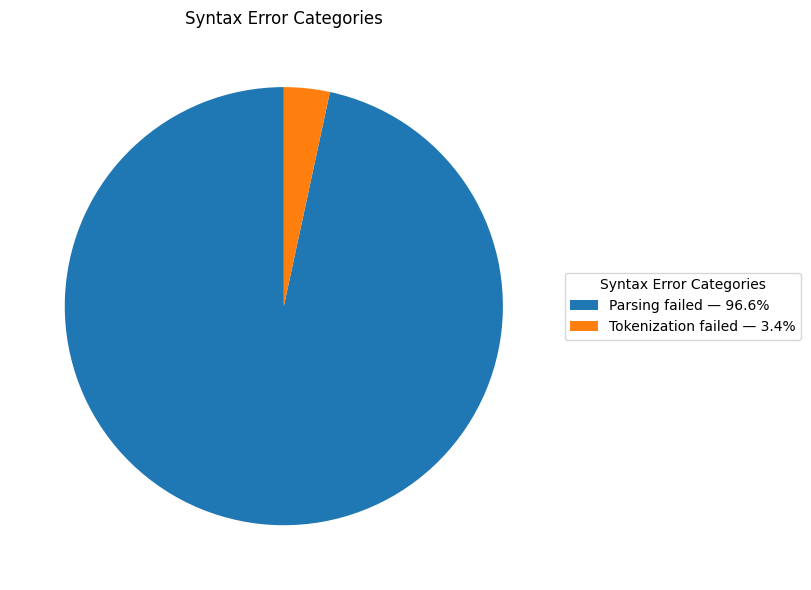

created_at test_result task_id error_type syntax_category  \
0 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
1 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
2 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
3 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
4 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
5 2025-04-08 05:53:38.494        None       8     syntax  Parsing failed   
6 2025-04-08 05:53:38.494        None      14     syntax  Parsing failed   
7 2025-04-08 05:53:38.494        None      14     syntax  Parsing failed   
8 2025-04-08 05:53:38.494        None      14     syntax  Parsing failed   
9 2025-04-08 05:53:38.494        None      14     syntax  Parsing failed   

                                                                                                                                                                                                                                             error_msg  \
0  [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Error: Expected token Identifier, but got Keyword(Trigger) at 1070, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
1                                                      [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Unexpected eof, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
2                                                      [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Unexpected eof, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
3                                                      [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Unexpected eof, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
4                                                      [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Unexpected eof, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
5                                                      [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Unexpected eof, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
6                 [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Error: Expected token ArrowOp, but got Colon at 583, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
7                                                           [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: Expected '.' after 'root', ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
8                                                           [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: Expected '.' after 'root', ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
9                                                           [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: Expected '.' after 'root', ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   

                                                                                                                  syntax_error  \
0  Error: Parsing failed\n\nCaused by:\n    CompilerError - Error: Expected token Identifier, but got Keyword(Trigger) at 1070   
1                                                      Error: Parsing failed\n\nCaused by:\n    CompilerError - Unexpected eof   
2                                    

In [3]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "syncode_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

experiment_name = f"signature_similarity_10_shot"
error_type = "syntax"
filter = {
    "eval_method": "3_fold",
    "model_name": "llama3.2:3b-instruct-fp16",
}
df = errors_to_df(experiment_name, filter=filter)

df["syntax_error"] = df["stderr"]
df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

df["tests_category"] = df["test_result"].apply(categorize_test_errors)
df["tests_error"] = df.apply(
    lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
    axis=1
)

# Show all rows
pd.set_option('display.max_rows', None)     

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each cell
pd.set_option('display.max_colwidth', None)

print(df.columns)
print(df["error_type"].unique())
filtered_df  = df[df["error_type"] == error_type][[
    "created_at",
    "test_result",
    "task_id", 
    "error_type",
    f"{error_type}_category", 
    "error_msg", 
    f"{error_type}_error", 
    "stderr", 
    "stdout",
    "code_candidate"
    
]]

errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
print(errors_count_df)
make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")

filtered_df.head(10)



In [ ]:

sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.db_service.data_visualization import visualize_error_flow_for_model



# Assuming the experiment 'GPT4_signature_exp1' exists,
# and you evaluated 100 candidates for model 'GPT-4':
# visualize_error_flow_for_model(experiment_name, "gpt-4o")
pretty_print_experiment_collections(experiment_name, filter={"eval_method": "hold_out"})


In [ ]:
import json
from my_packages.evaluation.midio_compiler import get_json_test_result


test = """
Installing dependencies for midio_example@0.1.0\n\nNo external dependencies\n\nBuilding package...\nPackage built successfully!\n\n{\n "num_tests": 1,\n "num_passed": 1,\n "test_results": [\n {\n "name": "Test text_match_wordz",\n "assertions": [\n {\n "kind": "Passed",\n "expect": "true",\n "actual": "true"\n },\n {\n "kind": "Passed",\n "expect": "true",\n "actual": "true"\n },\n {\n "kind": "Passed",\n "expect": "false",\n "actual": "false"\n }\n ],\n "passed": true\n }\n ]\n}CUSTOM WARNING: Orignal code starts with 'func' keyword, but added imports and modules manually\n
"""
import re
import json

def json_e(output):
    try:
        # Match the first full JSON object using balanced braces (basic greedy match)
        match = re.search(r'{.*}', output, re.DOTALL)
        if not match:
            return {}
        json_text = match.group(0)
        return json.loads(json_text)
    except json.JSONDecodeError as e:
        return {}

    
json_e(test)